In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data_df=pd.read_csv("https://raw.githubusercontent.com/sijuswamy/Intel-Unnati-sessions/main/heart.csv")


In [ ]:
data_df.isnull().sum()


age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

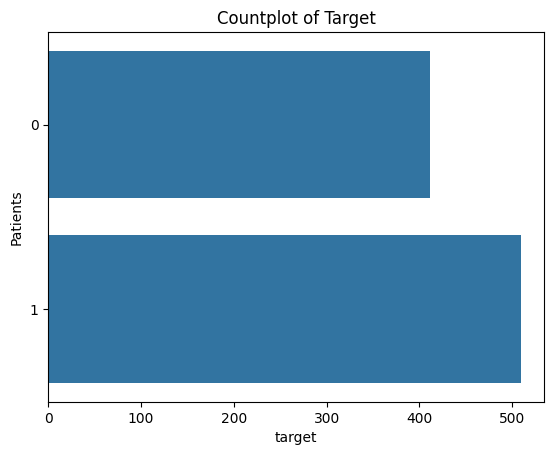

In [ ]:
#2. distribution of target variable.
data_df['target'] = np.where(data_df['target']!= 0, 1, 0)
data_df.head()
data_df['target'] = data_df['target'].astype('category')
sns.countplot(data_df['target'])

# Add labels
plt.title('Countplot of Target')
plt.xlabel('target')
plt.ylabel('Patients')
plt.show()

Let us proceed by splitting our training and test data and our input and target variables. Since we are using KNN, it is mandatory to scale our datasets too.

In [ ]:
# Create a list of categorical columns and numerical columns
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal','dataset']

num_cols = ['age','trestbps','chol','thalch','oldpeak']


In [ ]:
df_continuous = data_df[num_cols]
df_continuous.fillna(0, inplace=True)

<ipython-input-8-060a7bc2b174>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_continuous.fillna(0, inplace=True)


In [ ]:
# creating a Knn model
y = data_df["target"].values
x = df_continuous

#Scaling - mandatory for knn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
ss = StandardScaler()
x = ss.fit_transform(x)

#SPlitting into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3) # 70% training and 30% test


The intuition behind choosing the best value of k is beyond the scope of this article, but we should know that we can determine the optimum value of k when we get the highest test score for that value. For that, we can evaluate the training and testing scores for up to 20 nearest neighbors:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
train_score = []
test_score = []
k_vals = []

for k in range(1, 21):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)

    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)

    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)

To evaluate the max test score and the k values associated with it, run the following command:

In [ ]:
## score that comes from the testing set only
max_test_score = max(test_score)
test_scores_ind = [i for i, v in enumerate(test_score) if v == max_test_score]
print('Max test score {} and k = {}'.format(max_test_score * 100, list(map(lambda x: x + 1, test_scores_ind))))

Max test score 73.91304347826086 and k = [19]


Thus, we have obtained the optimum value of k to be 3, 11, or 20 with a score of 83.5. We will finalize one of these values and fit the model accordingly:

In [ ]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(3)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6920289855072463

Now, how do we evaluate whether this model is a ‘good’ model or not? For that, we use something called a Confusion Matrix:

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
y_pred = knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,87,46,133
1,39,104,143
All,126,150,276


In [ ]:
cm

array([[ 87,  46],
       [ 39, 104]])

In [ ]:
acc=np.sum(np.diag(cm))/np.sum(cm)
prec=cm[0,0]/(cm[0,0]+cm[1,0])
recal=cm[0,0]/(cm[0,0]+cm[0,1])
fscore=2*(prec*recal)/(prec+recal)


In [ ]:
print("Accuracy:", acc)
print("Precision: ",prec)
print("Recall: ",recal)
print("f1-score: ",fscore)

Accuracy: 0.6920289855072463
Precision:  0.6904761904761905
Recall:  0.6541353383458647
f1-score:  0.6718146718146719


All these measures in single function:

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.65      0.67       133
           1       0.69      0.73      0.71       143

    accuracy                           0.69       276
   macro avg       0.69      0.69      0.69       276
weighted avg       0.69      0.69      0.69       276



In [ ]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [ ]:
# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)

AUC: 0.729


In [ ]:
from sklearn.metrics import RocCurveDisplay

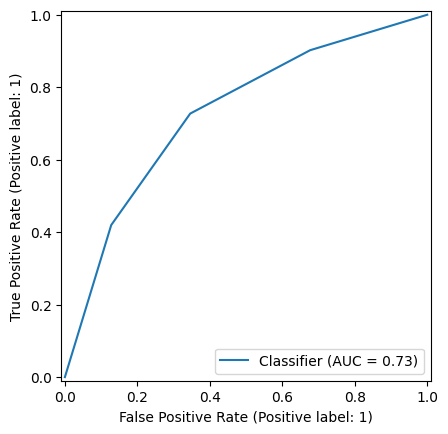

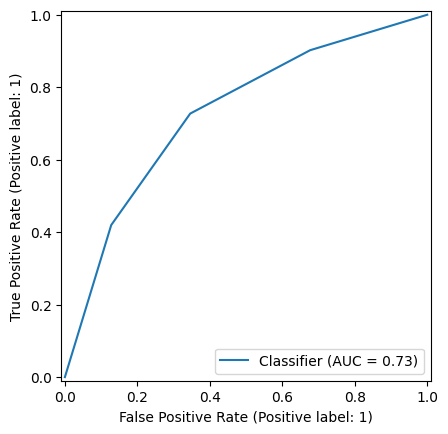

In [ ]:
# Create a RocCurveDisplay object
roc_curve_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba)

# Plot the ROC curve
roc_curve_display.plot()